# Demonstration of the compartment model module

In this notebook, we briefly demonstrate how this module can be used. We use an arterial input function that was actually measured (it is used for some of the automatic tests as well), generate a synthetic tissue concentration curve and fit some models to this curve. Most of this code is stolen from the test code.

We first import some libraries:

In [2]:
import numpy as np 
import  matplotlib.pyplot as plt # plotting
# some magic required for inline plotting in this notebook
%pylab inline 

import seaborn as sns # pretty plots

# seaborn setup for notebooks:
sns.set_context('talk')
sns.set_style('white')

from compartmentmodels.compartmentmodels import loaddata # to load the arterial input function
from compartmentmodels.compartmentmodels import TwoCXModel, TwoCUModel,CompartmentModel


Populating the interactive namespace from numpy and matplotlib


## Generation of synthetic data

First, we load an arterial input function from a (human readable) csv file; also, we calculate the absolute signal enhancement as an approximation to the contrast agent concentration:

In [3]:
time, aif1, aif2 = loaddata('tests/cerebralartery.csv') # we don't actually need aif1
aif = aif2- aif2[0:5].mean() # subtract the mean of the first six time points

Inspection of the numpy arrays time and aif reveals that these arrays are of type float64, have one dimension, have equal length and are hence suitable for plotting:

float64 (139L,)
float64 (139L,)


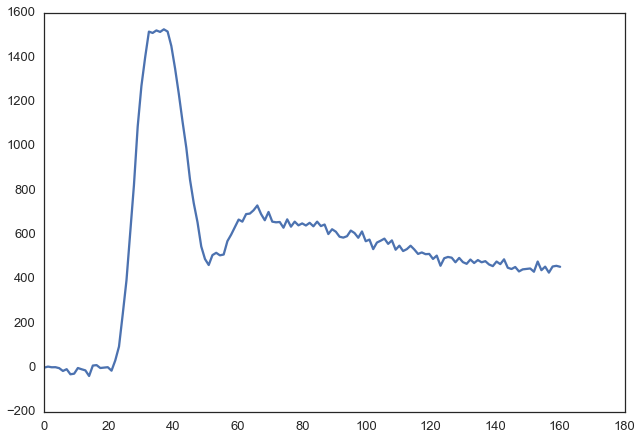

In [4]:
print time.dtype, time.shape
print aif.dtype, aif.shape

plt.plot(time, aif)

This arterial input function might suffer from some nonlinearties, but is perfectly sufficient for our purposes.  We can use it to calculate a synthetic tissue curve, we only need to provide some hemodynamic parameter. We can use a python dictionary for convenience and provide plasma flow $F_p$, plasma volume $v_p$, permeability surface area product $PS$ and interstitial volume $v_e$:

In [8]:
true_values = {'Fp': 31.0, 'vp': 11.2, 'PS': 4.9, 've': 13.2}   

Then, we can initialize a model instance. We need to provide the time vector (check), an arterial input function (check), a tissue curve (not yet available, so we pass anything that has the same length as time and aif), and the true values. Then, we use the dictionary with the true values and the aif to calculate a synthetic tissue curve adn we add some normally distributed noise. (*Note: usually, one would not have to generate synthetic tissue curves)

In [9]:
model=TwoCXModel(time=time, curve=aif, aif=aif, startdict=true_values)
model.curve = model.calc_modelfunction(model._parameters)                    
model.curve += 0.005 * model.curve.max() * np.random.randn(len(time))  

#we store this synthetic data in three vectors:
time=model.time
aif=model.aif
curve=model.curve

Now, we have a fully initialized instance of our two compartment model. We perfectly know our true hemodynamic parameters, because we have defined them above, and we now have three numpy vectors:

* a time vector
* an arterial input function
* a tissue curve

These three vectors usually come from a dynamic contrast-enhanced measurement. 

To conclude this section, we plot our synthetic data:

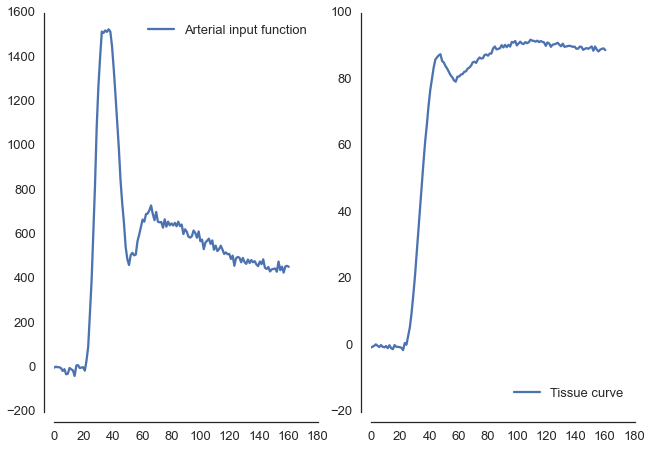

In [10]:
f, (ax1, ax2) = plt.subplots(1,2, sharex=True)
ax1.plot(model.time, model.aif, label='Arterial input function')
ax1.legend()

ax2.plot(model.time, model.curve, label='Tissue curve')
ax2.legend(loc=4)

# and, because seaborn is able to make great plots:
sns.despine(offset=10, trim=True)

## Model fitting

From the previous section, we have two synthetic concentration-time curves: an arterial input function and the corresponding tissue curve. Let us now fit a two-compartment exchange model to this data. First, we prepare some initial values and set up a model instance:

In [12]:
initial_values = {'Fp': 19.9,
                  'vp': 8.1,
                  'PS': 2.1,
                  've': 10.0}
model = TwoCXModel(time, curve, aif, startdict=initial_values)

Then, we can fit our model to the data and inspect the fit result:

In [13]:
fit_result=model.fit_model()
print model.OptimizeResult

  status: 0
 success: True
    nfev: 385
     fun: 23.188112127391818
       x: array([ 0.00518202,  0.04962761,  0.16690449,  0.00514108])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([ 113.91353425,   -5.22759791,   -0.18135395,    4.75431676])
     nit: 38


It appears that our fit was successful, the model function was evaluated 312 times, and the fit algorithm needed 34 iterations. The fit parameters themselves are not very enlightening, let's have a look at the model's readable parameters, and, for comparison, at the original, true values (a convenience that one seldom has):


In [14]:
print model.get_parameters()
print true_values

{'Fp': 31.092130491503422, 'PS': 4.9274567975756165, 'E': 0.13679936857770708, 've': 13.558250396363428, 'TP': 18.569196970841396, 'vp': 11.147580186322061, 'Iterations': 38, 'TE': 165.09429858056953}
{'Fp': 31.0, 'vp': 11.2, 've': 13.2, 'PS': 4.9}


We observe that $F_p$ and $v_p$ are quite close to the true values (check), and also, that $PS$ and $v_e$ appear to deviate from the true values. This deviation, however, is in accordance with tracer kinetics: The true interstitial transit time is in the order of the measurement time, so that the interstitial parameters cannot be estimated precisely.

To conclude this section, let us look at the fitted model curve:


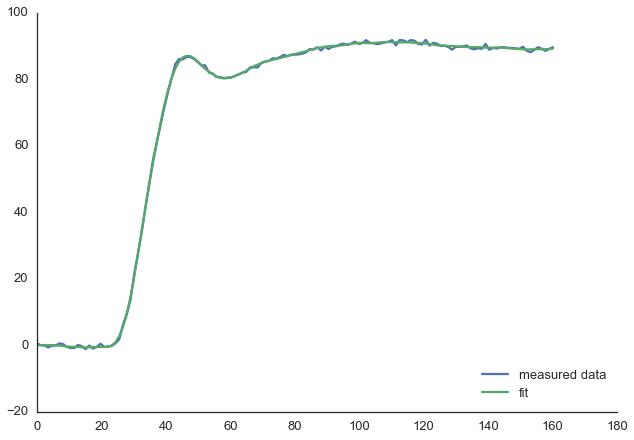

In [62]:
plt.plot(time,curve, label = 'measured data') # the original curve
plt.plot(time, model.fit, label = 'fit') # the fitted curve
plt.legend(loc=4)
sns.despine(trim=True)

Perfect fit.

This was a short demo of our implementation of tracer kinetic models. In this demo, we have only covered the tip of the iceberg. As of now, we have implemented additionally two more models, a compartment uptake model and a one-compartment model. This module is currently under development and we plan to extend it further.